<a href="https://colab.research.google.com/github/vigneshgk7/Machine_Learning_Projects/blob/main/nanaoVLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import math, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import transforms

## Variables



In [2]:
IMG_SIZE=32
EMBED_DIM=32
ATTENTION_HEADS=4
BATCH_SIZE=12
EPOCHS=60
LR=1e-3
TEMPERATURE=0.07
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
print(device)

cuda


## Synthetic Dataset properties

In [4]:
colors=['red','green','blue','yellow','purple','orange','pink','brown','gray']
shapes=['square','circle','triangle']
positions=['left','right','top','bottom','top-left','top-right','bottom-left','bottom-right']

## Drawing image shapes

In [5]:
def draw_sample(color,shape,position,img_size):
    img=Image.new('RGB',(img_size, img_size),(255,255,255))
    draw=ImageDraw.Draw(img)

    margin=6
    h=w= img_size -2* margin

    #Calculate X coordinates
    if 'left' in position:
        x0=margin
        x1=margin+w//2
    elif 'top=left' in position:
        x0=margin
        x1=margin+w//2
    elif 'bottom_left' in position:
        x0=margin
        x1=margin+w//2

    elif 'right' in position:
        x0=margin+w//2
        x1=img_size-margin
    elif 'top-right' in position:
        x0=margin+w//2
        x1=img_size-margin
    elif 'bottom-right' in position:
        x0=margin+w//2
        x1=img_size-margin
    else:
        x0=margin+w//4
        x1=margin + 3* w//4

    #Calculate Y coordinates
    if 'top' in position:
        y0=margin
        y1=margin+h//2
    elif 'top-left' in position:
        y0=margin
        y1=margin+h//2
    elif 'top-right' in position:
        y0=margin
        y1=margin+h//2

    elif 'bottom' in position:
        y0=margin+h//2
        y1=img_size-margin
    elif 'bottom-left' in position:
        y0=margin+h//2
        y1=img_size-margin
    elif 'bottom-right' in position:
        y0=margin+h//2
        y1=img_size-margin

    else:
      y0=margin+h//4
      y1=margin + 3* h//4

    if shape=='square':
        draw.rectangle([(x0,y0),(x1,y1)],fill=color,outline='black')
    elif shape=='circle':
        draw.ellipse([(x0,y0),(x1,y1)],fill=color,outline='black')
    else:
      draw.polygon([ ((x0+x1)//2,y0) ,(x0,y0),(x1,y1)],fill=color,outline='black')
    return img



## Class for building the dataset

In [15]:
class ShapesDataset():
  def __init__(self):
    self.images=[]
    self.captions=[]

    for c in colors:
      for s in shapes:
        for p in positions:
          img=draw_sample(c,s,p,64)
          cap=f"{c} {s} {p}"

          self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
          self.captions.append(cap)
    self.vocab,self.word2idx=self.build_vocab(self.captions)

  def build_vocab(self, texts):
    words=sorted({w for t in texts for w in t.split()})
    vocab=['[CLS]']+words
    w2i={w:i for i,w in enumerate(vocab)}
    return vocab,w2i

  def __len__(self):
    return len(self.images)

  def encode_text(self,text):
    toks=[self.word2idx['[CLS]']]+ [self.word2idx[w] for w in text.split()]
    return torch.tensor(toks,dtype=torch.long)

  def __getitem__(self,idx):
    return self.images[idx],self.encode_text(self.captions[idx])


## Create full dataset

In [16]:
full_ds=ShapesDataset()
VOCAB_SIZE=len(full_ds.vocab)
print(VOCAB_SIZE)


21


## Train-val data creation

In [18]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])
print(train_size, val_size)

172 44


## DataLoader

In [20]:

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

## Display a sample data point

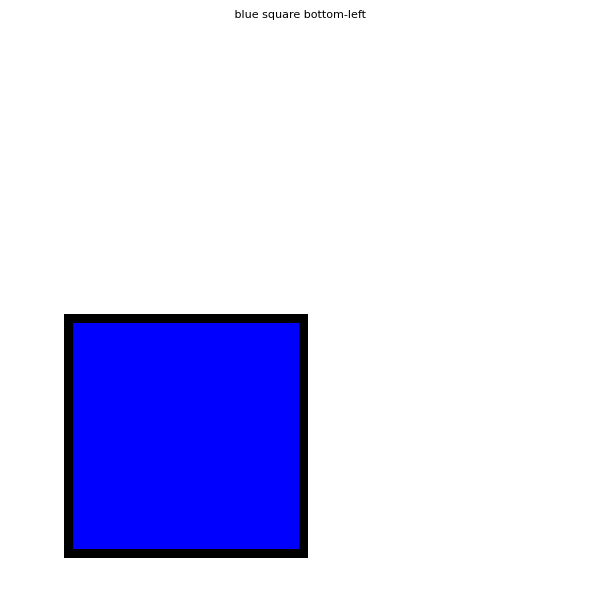

In [21]:
imgs, encoded_caps = next(iter(train_loader))
idx = random.randint(0, len(imgs) - 1)

# Convert to displayable image
img = (imgs[idx].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

# Decode caption
caption_tokens = encoded_caps[idx].tolist()
caption = " ".join([full_ds.vocab[token] for token in caption_tokens if token in range(len(full_ds.vocab))])

# Remove [CLS] token from the displayed caption
caption = caption.replace('[CLS]', '')

plt.figure(figsize=(7.5, 7.5))
plt.imshow(img)
plt.title(caption, fontsize=8)
plt.axis("off")
plt.show()

## Image Encoder

In [22]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU()
        )

        self.projection = nn.Linear(256, embed_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.convolutions(x)

        # Global average pooling over spatial dimensions
        x = x.mean(dim=[2, 3])

        x = self.projection(x)
        x = F.normalize(self.layer_norm(x), dim=1)

        return x

## Text Encoder

In [ ]:
# class TextEncoder(nn.Module):
#     def __init__(self, embed_dim=EMBED_DIM,num_heads= ATTENTION_HEADS,vocab_size=VOCAB_SIZE,context_window=4):
#         super().__init__()
#         self.token_embedding = nn.Embedding(vocab_size, embed_dim)
#         self.position_embedding = nn.Embedding(context_window, embed_dim)
#         self.mha = nn.MultiheadAttention(embed_dim, num_heads)
#         self.norm=nn.LayerNorm(embed_dim)

#     def forward(self, toks):
#         N, L = toks.shape
#         # Create positional embedding indices
#         position_emb_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)

#         # Get embedding vectors
#         position_embedding_vectors = self.position_embedding(position_emb_ids)
#         token_embedding_vectors = self.token_embedding(toks)

#         # Combine and pass through Multi-Head Attention
#         x = token_embedding_vectors + position_embedding_vectors
#         x = self.mha(x, x, x)[0]

#         # Pool (extracting the [CLS] or first token representation)
#         x = x[:, 0]

#         # Project and Normalize
#         x = self.projection(x)
#         x = F.normalize(self.norm(x), dim=-1)

#         return x


In [23]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len=50):
        super().__init__()
        # 1. Map tokens to vectors
        self.token_embedding = nn.Embedding(vocab_size, 256)

        # 2. Map positions to vectors
        self.position_embedding = nn.Embedding(max_len, 256)

        # 3. Multi-Head Attention layer
        self.mha = nn.MultiheadAttention(embed_dim=256, num_heads=8, batch_first=True)

        # 4. THE MISSING PROJECTION LAYER
        # This maps the attention output to the shared CLIP space
        self.projection = nn.Linear(256, embed_dim)

        # 5. Normalization layer
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, toks):
        N, L = toks.shape
        position_emb_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N, L)

        position_embedding_vectors = self.position_embedding(position_emb_ids)
        token_embedding_vectors = self.token_embedding(toks)

        x = token_embedding_vectors + position_embedding_vectors
        x = self.mha(x, x, x)[0]

        # Pool by taking the first token
        x = x[:, 0]

        # Now self.projection exists!
        x = self.projection(x)
        x = F.normalize(self.norm(x), dim=1)

        return x

## CLIP Loss


In [24]:
def clip_loss(img_emb, txt_emb, temperature = TEMPERATURE):
    # Calculate cosine similarity scaled by temperature
    logits = img_emb @ txt_emb.T / temperature

    # Targets are the diagonal (where image and text indices match)
    targets = torch.arange(img_emb.size(0), device = img_emb.device)

    # Symmetric Cross Entropy
    loss_i = F.cross_entropy(logits, targets)
    loss_t = F.cross_entropy(logits.T, targets)

    return ((loss_i + loss_t) / 2.0)

## Model , Data , Optimizer

In [31]:
# Initialize models
print(VOCAB_SIZE, EMBED_DIM)
img_enc = ImageEncoder(embed_dim=EMBED_DIM).to(device)
txt_enc = TextEncoder(vocab_size=VOCAB_SIZE,embed_dim=EMBED_DIM).to(device)

# Combine parameters for the optimizer
params = list(img_enc.parameters()) + list(txt_enc.parameters())
optimizer = torch.optim.AdamW(params, lr = LR)

21 32


## Display embeddings before training

In [33]:
def show_image(t, title=None):
    # Convert from (C, H, W) to (H, W, C) and scale to 0-255
    img = (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    plt.figure(figsize=(2.2, 2.2))
    plt.axis('off')

    if title:
        plt.title(title, fontsize=8)

    plt.imshow(img)
    plt.show()

In [ ]:
# img_enc.eval(); txt_enc.eval()

# with torch.no_grad():
#     random_idx = random.randrange(len(full_ds))

#     # Corrected Unpacking (expecting 2 values)
#     sample_img, sample_toks = full_ds[random_idx]

#     # Decode caption for printing
#     sample_cap = " ".join([full_ds.vocab[t] for t in sample_toks.tolist() if t in range(len(full_ds.vocab))])

#     sample_img = sample_img.unsqueeze(0).to(device)
#     sample_toks = sample_toks.unsqueeze(0).to(device)

#     pre_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
#     pre_train_txt_emb = txt_enc(sample_toks).squeeze(0).cpu().numpy()

# #Display sample image and caption
# print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
# show_image(sample_img.squeeze(0).cpu())



Sample image and caption for embeddings visualization: 'pink triangle right'


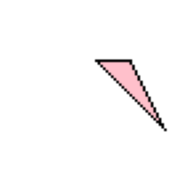

In [34]:
img_enc.eval(); txt_enc.eval()

with torch.no_grad():
    random_idx = random.randrange(len(full_ds))

    # Unpack the 2 values from dataset
    sample_img_cpu, sample_toks = full_ds[random_idx]

    # Decode caption and REMOVE [CLS]
    sample_cap = " ".join([full_ds.vocab[t] for t in sample_toks.tolist() if t in range(len(full_ds.vocab))])
    sample_cap = sample_cap.replace('[CLS]', '').strip() # This removes the tag and extra spaces

    # Prepare tensors for the models
    sample_img = sample_img_cpu.unsqueeze(0).to(device)
    sample_toks_gpu = sample_toks.unsqueeze(0).to(device)

    # Generate embeddings
    pre_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
    pre_train_txt_emb = txt_enc(sample_toks_gpu).squeeze(0).cpu().numpy()

# Display sample image and cleaned caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img.squeeze(0).cpu())

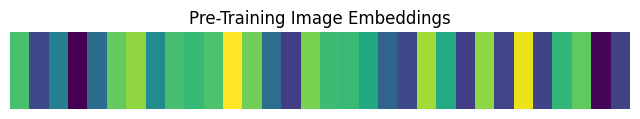

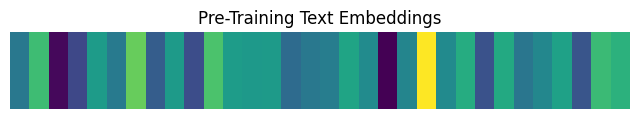

In [35]:
#Generate embeddings
def plot_embedding(embedding,title):
  plt.figure(figsize=(8,1))
  plt.imshow(embedding.reshape(1,-1),aspect="auto",cmap="viridis")
  plt.title(title)
  plt.axis("off")
  plt.show()
plot_embedding(pre_train_img_emb,"Pre-Training Image Embeddings")
plot_embedding(pre_train_txt_emb,"Pre-Training Text Embeddings")

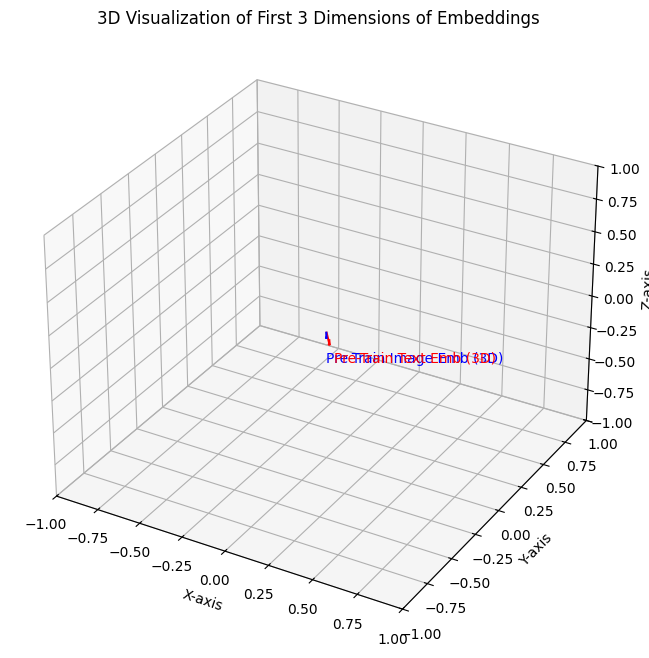

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_arrows(embeddings, titles):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Origin for the arrows
    origin = [0, 0, 0]

    colors = ['blue', 'red']

    for i, emb in enumerate(embeddings):
        # Use only the first 3 dimensions for 3D plotting
        vec = emb[:3]
        ax.quiver(*origin, *vec, color=colors[i], length=np.linalg.norm(vec), normalize=False)
        ax.text(vec[0], vec[1], vec[2], titles[i], color=colors[i])

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('3D Visualization of First 3 Dimensions of Embeddings')
    plt.show()

# Prepare the embeddings (first 3 dimensions) and titles
embeddings_to_plot = [
    pre_train_img_emb[:3],
    pre_train_txt_emb[:3]
]
titles_to_plot = [
    'Pre-Train Image Emb (3D)',
    'Pre-Train Text Emb (3D)'
]

plot_3d_arrows(embeddings_to_plot, titles_to_plot)


Note here:
Before training the model the embeddings looks completely different when we compare dimension to dimension of the image and text embeddings.
Very few dimension are exactly matching

## Training loop

In [38]:
# @title
best_val = float('inf')

for epoch in range(1, EPOCHS + 1):
    img_enc.train(); txt_enc.train()
    total = 0.0

    # Training Phase
    # FIX: Changed from "imgs, toks, _" to "imgs, toks"
    for imgs, toks in train_loader:
        imgs = imgs.to(device); toks = toks.to(device)
        optimizer.zero_grad(set_to_none=True)

        ie = img_enc(imgs); te = txt_enc(toks)
        loss = clip_loss(ie, te)
        loss.backward()
        optimizer.step()

        total += loss.item() * imgs.size(0)

    train_loss = total / (len(train_loader) * BATCH_SIZE)

    # Quick Validation Phase
    img_enc.eval(); txt_enc.eval()
    with torch.no_grad():
        vtotal, n = 0.0, 0
        # FIX: Changed from "imgs, toks, _" to "imgs, toks"
        for imgs, toks in val_loader:
            imgs = imgs.to(device); toks = toks.to(device)
            vtotal += clip_loss(img_enc(imgs), txt_enc(toks)).item() * imgs.size(0)
            n += imgs.size(0)
        val_loss = vtotal / n

    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
    best_val = min(best_val, val_loss)

Epoch 01 | train 2.4558 | val 2.4138
Epoch 02 | train 2.3511 | val 2.4098
Epoch 03 | train 2.3467 | val 2.4071
Epoch 04 | train 2.3295 | val 2.3203
Epoch 05 | train 2.1937 | val 2.1784
Epoch 06 | train 2.0905 | val 2.0802
Epoch 07 | train 1.9192 | val 1.8985
Epoch 08 | train 1.6897 | val 1.5514
Epoch 09 | train 1.3130 | val 1.0705
Epoch 10 | train 0.8997 | val 0.6601
Epoch 11 | train 0.7409 | val 0.5400
Epoch 12 | train 0.6017 | val 0.4536
Epoch 13 | train 0.6285 | val 0.4615
Epoch 14 | train 0.5281 | val 0.4725
Epoch 15 | train 0.4783 | val 0.4409
Epoch 16 | train 0.5615 | val 0.4738
Epoch 17 | train 0.4496 | val 0.5342
Epoch 18 | train 0.5912 | val 0.4329
Epoch 19 | train 0.4495 | val 0.3742
Epoch 20 | train 0.4341 | val 0.3713
Epoch 21 | train 0.4329 | val 0.3621
Epoch 22 | train 0.8990 | val 1.0979
Epoch 23 | train 0.7174 | val 0.5362
Epoch 24 | train 0.4780 | val 0.4303
Epoch 25 | train 0.4747 | val 0.3191
Epoch 26 | train 0.3449 | val 0.3177
Epoch 27 | train 0.2978 | val 0.2697
E

## Post training  Results and Visualization



Sample image and caption for embeddings visualization: 'pink triangle right'


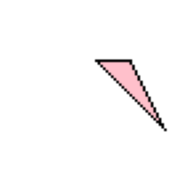

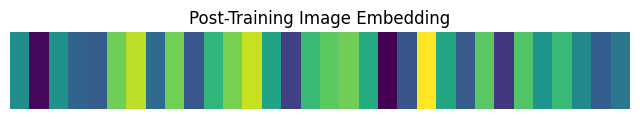

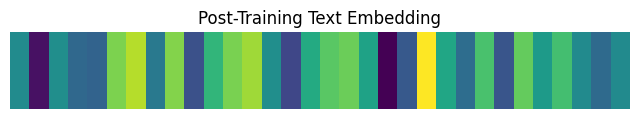

In [39]:
# @title
img_enc.eval(); txt_enc.eval()

with torch.no_grad():
    # Use the same random index as before training for comparison
    sample_img, sample_toks= full_ds[random_idx]

    # Prepare tensors
    sample_img_tensor = sample_img.unsqueeze(0).to(device)
    sample_toks_tensor = sample_toks.unsqueeze(0).to(device)

    # Generate Post-Training Embeddings
    post_train_img_emb = img_enc(sample_img_tensor).squeeze(0).cpu().numpy()
    post_train_txt_emb = txt_enc(sample_toks_tensor).squeeze(0).cpu().numpy()

# Display the sample image and cleaned caption
print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
show_image(sample_img_tensor.squeeze(0).cpu())

# Plot the resulting embeddings
plot_embedding(post_train_img_emb, "Post-Training Image Embedding")
plot_embedding(post_train_txt_emb, "Post-Training Text Embedding")

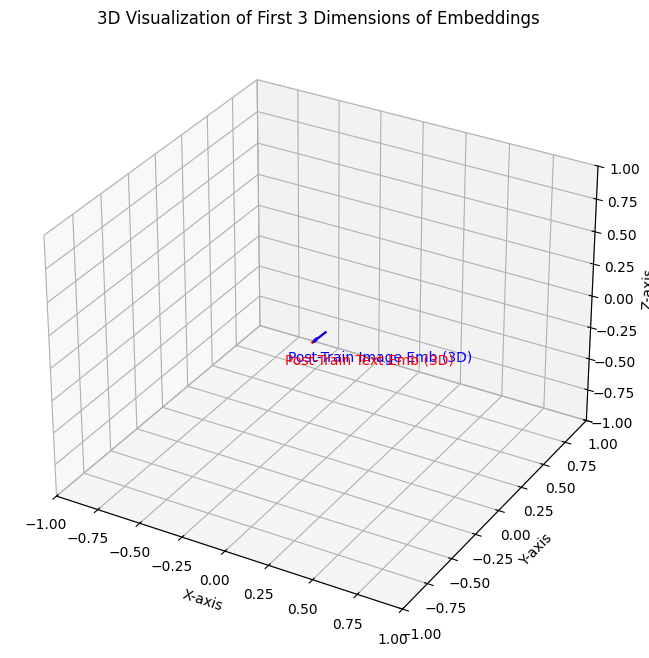

In [40]:
# Prepare the post-training embeddings (first 3 dimensions) and titles
embeddings_to_plot_post = [
    post_train_img_emb[:3],
    post_train_txt_emb[:3]
]
titles_to_plot_post = [
    'Post-Train Image Emb (3D)',
    'Post-Train Text Emb (3D)'
]

plot_3d_arrows(embeddings_to_plot_post, titles_to_plot_post)


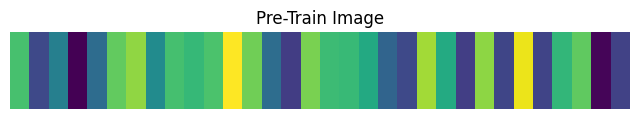

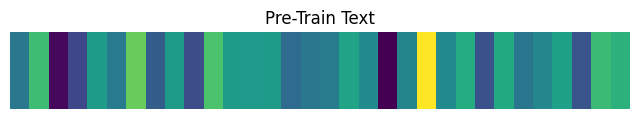

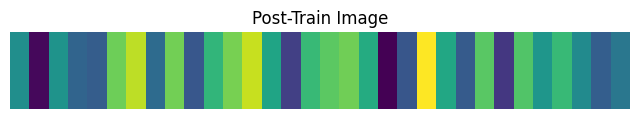

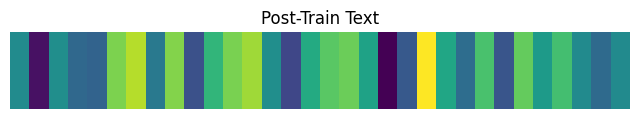

In [41]:
# Visualize pre-training alignment
plot_embedding(pre_train_img_emb, "Pre-Train Image")
plot_embedding(pre_train_txt_emb, "Pre-Train Text")

# Visualize post-training alignment (they should look more similar)
plot_embedding(post_train_img_emb, "Post-Train Image")
plot_embedding(post_train_txt_emb, "Post-Train Text")

In [ ]:
import torch.nn.functional as F

# Convert numpy arrays back to tensors if necessary
pre_img_tensor = torch.from_numpy(pre_train_img_emb)
pre_txt_tensor = torch.from_numpy(pre_train_txt_emb)
post_img_tensor = torch.from_numpy(post_train_img_emb)
post_txt_tensor = torch.from_numpy(post_train_txt_emb)

# Calculate Dot Product (Cosine Similarity)
# Since they are normalized, dot product = cosine similarity
pre_similarity = torch.dot(pre_img_tensor, pre_txt_tensor).item()
post_similarity = torch.dot(post_img_tensor, post_txt_tensor).item()

print(f"Comparison for Caption: '{sample_cap}'")
print("-" * 40)
print(f"Pre-training Dot Product:  {pre_similarity:.4f}")
print(f"Post-training Dot Product: {post_similarity:.4f}")
print("-" * 40)
print(f"Improvement: {((post_similarity - pre_similarity)):.4f}")

Comparison for Caption: 'green triangle bottom'
----------------------------------------
Pre-training Dot Product:  -0.0970
Post-training Dot Product: 0.9620
----------------------------------------
Improvement: 1.0590


In [ ]:
## Build text bank for retrieval on val dataset
## Validation embedding generation

In [46]:
img_enc.eval(); txt_enc.eval()
val_imgs_list, val_toks_list, val_caps = [], [], []

with torch.no_grad():
    for imgs, toks in val_loader: # Only unpack 2 values
        # 1. Collect raw data for retrieval database
        val_imgs_list.append(imgs)
        val_toks_list.append(toks)

        # 2. Decode tokens back to strings for val_caps
        for t in toks:
            cap_str = " ".join([full_ds.vocab[i] for i in t.tolist() if i in range(len(full_ds.vocab))])
            val_caps.append(cap_str.replace('[CLS]', '').strip())

    # 3. Create the embedding tensors
    val_imgs = torch.cat(val_imgs_list).to(device)
    val_toks = torch.cat(val_toks_list).to(device)

    img_emb = img_enc(val_imgs)
    txt_emb = txt_enc(val_toks)
    print(txt_emb[0])
    print(img_emb[0])
print(f"Successfully processed {len(val_caps)} validation samples.")

tensor([ 0.0822, -0.1621,  0.3447, -0.0903,  0.0128, -0.0027,  0.1418,  0.2513,
        -0.2565,  0.2794,  0.2274, -0.0477, -0.0025,  0.1174,  0.0229,  0.1047,
        -0.0266,  0.0057,  0.1925,  0.0430,  0.2169, -0.3364,  0.0187, -0.0964,
        -0.1065, -0.1021,  0.0476, -0.4553, -0.1360,  0.0386, -0.2398, -0.1231],
       device='cuda:0')
tensor([ 0.0427, -0.1453,  0.3087, -0.1421,  0.0062,  0.0267,  0.0987,  0.2563,
        -0.2099,  0.2551,  0.2241, -0.0415, -0.0446,  0.1728,  0.0406,  0.1639,
        -0.0264,  0.0446,  0.1827,  0.0409,  0.2493, -0.2944, -0.0538, -0.0658,
        -0.1257, -0.1321,  0.0466, -0.4595, -0.1323,  0.1106, -0.2508, -0.1761],
       device='cuda:0')
Successfully processed 44 validation samples.


## Retrieval Helper Function

In [47]:
# @title
def topk_text_for_images(k=3, idxs=None):
    if idxs is None:
        idxs = np.random.choice(len(val_caps), size=1, replace=False)

    # Similarity as softmax of the dot product
    sims = (img_emb @ txt_emb.t()).softmax(dim=1)

    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nImage {i} best captions:")
        for j in best:
            print(" -", val_caps[j])
        show_image(val_imgs[i].cpu())

def topk_images_for_text(k=3, idxs=None):
    if idxs is None:
        idxs = np.random.choice(len(val_caps), size=1, replace=False)

    # Similarity as softmax (text to image)
    sims = (txt_emb @ img_emb.t()).softmax(dim=1)

    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nText '{val_caps[i]}' best images:")
        for j in best:
            show_image(val_imgs[j].cpu(), title=f"match {val_caps[j]}")

## Demo: Show a few text to image and image to text retrievals


Image 41 best captions:
 - yellow circle bottom-left


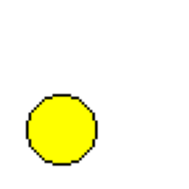


Text 'gray triangle left' best images:


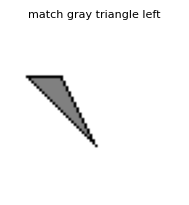

In [48]:
# @title
# Find the single best caption for a random image
topk_text_for_images(k=1)

# Find the single best image for a random text prompt
topk_images_for_text(k=1)

[link text](https://)First task is
-Based on the image the model should generate the caption

Second task
-Based on the caption, the model should give the image